In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

# !cp '/content/drive/MyDrive/aiactive/augmented_data.zip' 'augmented_data.zip'
# !cp '/content/drive/MyDrive/aiactive/test_data.zip' 'test_data.zip'

# !unzip 'augmented_data.zip'
# !unzip 'test_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: augmented_data/crossover/augmented_549.jpg  
  inflating: augmented_data/crossover/augmented_563.jpg  
  inflating: augmented_data/crossover/augmented_520.jpg  
  inflating: augmented_data/crossover/crossover-back (327).jpg  
  inflating: augmented_data/crossover/augmented_396.jpg  
  inflating: augmented_data/crossover/crossover-front (446).jpg  
  inflating: augmented_data/crossover/augmented_922.jpg  
  inflating: augmented_data/crossover/crossover-front (30).jpg  
  inflating: augmented_data/crossover/augmented_149.jpg  
  inflating: augmented_data/crossover/augmented_350.jpg  
  inflating: augmented_data/crossover/augmented_695.jpg  
  inflating: augmented_data/crossover/augmented_797.jpg  
  inflating: augmented_data/crossover/augmented_399.jpg  
  inflating: augmented_data/crossover/augmented_792.jpg  
  inflating: augmented_data/crossover/crossover-front (388).jpg  
  inflating: augmented_data/crossover/augmented_4

In [20]:
import os
import time
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adamax
from torchsummary import summary
from torchvision import datasets
from torchvision.models import vgg16, mobilenet_v3_small
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
num_classes = 8
batch_size = 16
IMAGE_SIZE = (300, 300)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def images_transforms():
    data_transformation = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])     
    
    return data_transformation

In [5]:
trainig_path = 'augmented_data'
test_path = 'test'
dataset = datasets.ImageFolder(trainig_path, transform=images_transforms())
targets = dataset.targets

train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

test_dataset = datasets.ImageFolder(test_path, transform=images_transforms())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# trainig_path = 'augmented_data'
# test_path = 'test'
# dataset = datasets.ImageFolder(trainig_path, transform=images_transforms())

# trainset, valset = random_split(dataset, [8715 , 966])
# train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

# test_dataset = datasets.ImageFolder(test_path, transform=images_transforms())
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
model = mobilenet_v3_small(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=64, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=64, out_features=32, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=32, out_features=num_classes, bias=True)
  )

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [8]:
model = model.to(device)

In [9]:
IMAGE_SIZE = (300, 300)
IMAGE_SIZE = (3,) + IMAGE_SIZE
print(summary(model, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             432
       BatchNorm2d-2         [-1, 16, 150, 150]              32
         Hardswish-3         [-1, 16, 150, 150]               0
            Conv2d-4           [-1, 16, 75, 75]             144
       BatchNorm2d-5           [-1, 16, 75, 75]              32
              ReLU-6           [-1, 16, 75, 75]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 75, 75]               0
           Conv2d-13           [-1, 16, 75, 75]             256
      BatchNorm2d-14           [-1, 16,

In [10]:
epochs = 100
n_steps = len(train_loader)
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(),lr=learning_rate)

In [25]:
def test(model,testloader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        y_pred = []
        y_actual = []
        for _, (images,labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs=model(images)
            
            y_actual += list(np.array(labels.detach().cpu()).flatten())
            _, predictes = torch.max(outputs,1)
            y_pred += list(np.array(predictes.detach().cpu()).flatten())
            n_samples += labels.shape[0]

            n_correct += (predictes==labels).sum().item()
            
        y_actual = np.array(y_actual).flatten()
        y_pred = np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual, y_pred, target_names=dataset.classes)
        print(f"{acc}")
        print("Confusion matric :\n")

        labels = dataset.classes
        cm = confusion_matrix(y_actual, y_pred)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix of the classifier')
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        print()

In [12]:
def train(model, train_loader, criterion, optimizer, val_loader, epochs=25):
    train_losses, val_losses, train_acc, val_accuracies, train_acc_epoch, val_acc_epoch, y_actual, y_pred = [], [], [], [], [], [], [], []
    wait = 0
    patience = 5
    best_acc = 0.0
    min_loss = np.Inf
    if not os.path.exists("models") : os.mkdir("models")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} : ")
        y_actual, y_pred = [], []
        train_loss, val_loss = 0, 0

        # Train the model
        model.train()
        for step, (images, labels) in enumerate(train_loader):
            start_time = time.time()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Loss and accuracy
            train_loss += loss.item()
            
            _, predictes = torch.max(outputs, dim=1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())

            acc = accuracy_score(y_actual, y_pred)
            end_time = time.time()
            ETA = (end_time-start_time)*(n_steps-step)
            print('\rstep [%d/%d] : loss = %.4f, accuracy = %.4f, ETA = %d sec ' % (step, n_steps, train_loss/(step+1), acc, ETA), end='')
        train_acc.append(accuracy_score(y_actual, y_pred))
        print('\rstep [%d/%d] : loss = %.4f, accuracy = %.4f ' % (step+1, n_steps, train_loss/(step+1), acc), end='')


        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs, 1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_accuracies.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_acc = train_acc[-1]
        val_acc = val_accuracies[-1]
        train_acc_epoch.append(training_acc)
        val_acc_epoch.append(val_acc)

        # Updating best validation accuracy
        if best_acc < val_acc:
            best_acc = val_acc

        print(", val_loss = %.4f, val_accuracy = %.4f" % (val_loss, val_acc))

        wait += 1
        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'models/mob.pt')
            print("val_loss improved from %.4f to %.4f, model saved to models/mob.pt" % (min_loss, val_loss))
            min_loss = val_loss
            wait = 0

        else :
            print("val_loss did not improve, skip checkpoint")
        print('=' * 80)

        # Early stopping
        if wait >= patience:
            print(f"val_loss did not improved for series of {wait} epochs, Apply early stopping")
            break
        
    return train_losses, val_losses, train_acc, val_acc, train_acc_epoch, val_acc_epoch

In [13]:
train_losses, val_losses, train_acc, val_acc, train_acc_epoch, val_acc_epoch = train(model, train_loader, criterion, optimizer, val_loader, epochs)

Epoch 1/100 : 
step [484/484] : loss = 1.7858, accuracy = 0.3204 , val_loss = 1.3730, val_accuracy = 0.3697
val_loss improved from inf to 1.3730, model saved to models/mob.pt
Epoch 2/100 : 
step [484/484] : loss = 1.4099, accuracy = 0.4556 , val_loss = 1.0859, val_accuracy = 0.4868
val_loss improved from 1.3730 to 1.0859, model saved to models/mob.pt
Epoch 3/100 : 
step [484/484] : loss = 1.2320, accuracy = 0.5200 , val_loss = 0.9500, val_accuracy = 0.5477
val_loss improved from 1.0859 to 0.9500, model saved to models/mob.pt
Epoch 4/100 : 
step [484/484] : loss = 1.1239, accuracy = 0.5621 , val_loss = 0.8628, val_accuracy = 0.5842
val_loss improved from 0.9500 to 0.8628, model saved to models/mob.pt
Epoch 5/100 : 
step [484/484] : loss = 1.0550, accuracy = 0.5885 , val_loss = 0.8109, val_accuracy = 0.6119
val_loss improved from 0.8628 to 0.8109, model saved to models/mob.pt
Epoch 6/100 : 
step [484/484] : loss = 1.0162, accuracy = 0.6074 , val_loss = 0.7553, val_accuracy = 0.6335
val_l

In [14]:
!cp 'models/mob.pt' '/content/drive/MyDrive/aiactive/mob.pt'

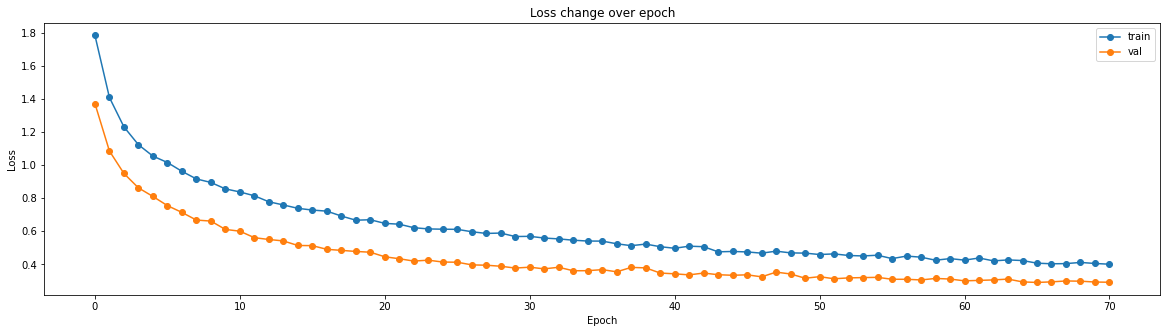

In [15]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

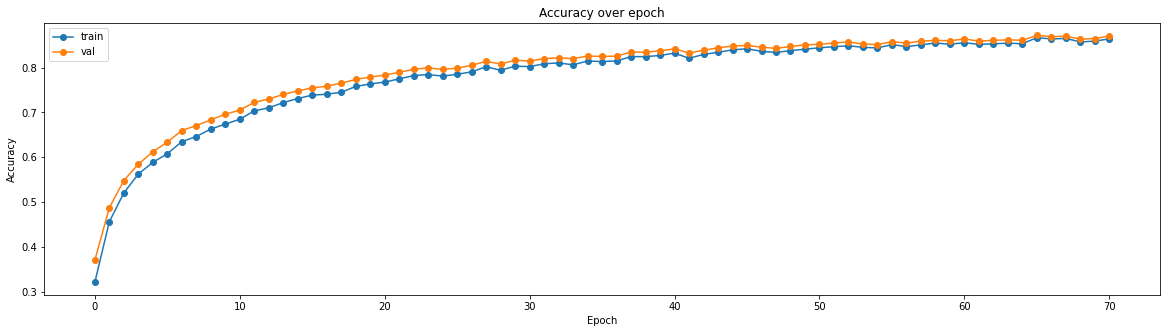

In [16]:
plt.figure(figsize=(20,5))
plt.plot(train_acc_epoch, '-o', label="train")
plt.plot(val_acc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [17]:
torch.save(model,'/content/drive/MyDrive/aiactive/saved_mob_model.h5')

[0 1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         bus       0.78      0.90      0.84        20
   crossover       0.85      0.73      0.79       120
   hatchback       0.55      0.68      0.61       105
  motorcycle       1.00      1.00      1.00        22
pickup-truck       0.88      0.90      0.89        90
       sedan       0.91      0.90      0.90       396
       truck       0.92      0.89      0.91        65
         van       0.91      0.86      0.88       105

    accuracy                           0.85       923
   macro avg       0.85      0.86      0.85       923
weighted avg       0.86      0.85      0.85       923

Confusion matric :



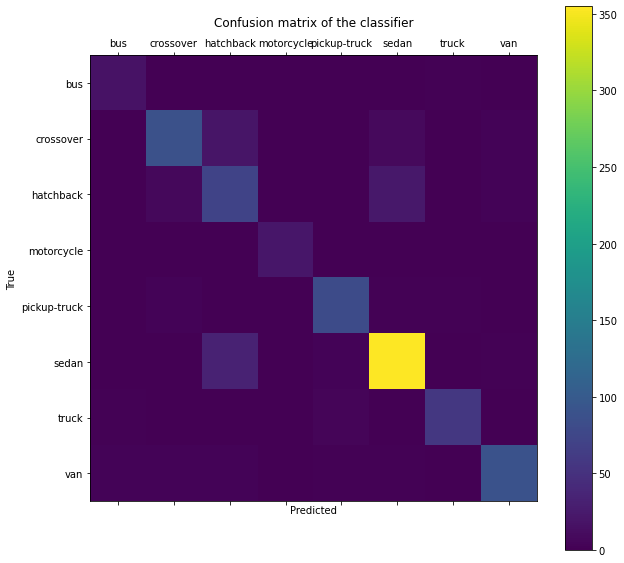

In [26]:
import seaborn as sns

model.load_state_dict(torch.load('models/mob.pt'))
test(model, test_loader)